
let's start with TensorFlow.


---


Multicategorical classification 


#  Import Libraries 

In [1]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

print (tf.__version__)
          
gEpochs=30


2.9.0


## Data

In [2]:
#obtain the data from microsoft.com
#the same dataset is available in kaggle but with a different organization
#https://www.kaggle.com/competitions/dogs-vs-cats/data

#If it dosn't run be sure to have wget installed in your local machine. It works fine in Colab. 

!wget --no-check-certificate \
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip \-O /tmp/catsvsdogs.zip

--2022-07-22 12:39:48--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.123.32.250
Connecting to download.microsoft.com (download.microsoft.com)|92.123.32.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/catsvsdogs.zip’

/tmp/catsvsdogs.zip 100%[===================>] 786,67M  19,3MB/s    in 41s     

2022-07-22 12:40:29 (19,2 MB/s) - ‘/tmp/catsvsdogs.zip’ saved [824887076/824887076]



Dataset:
This dataset is really common and used in a lot of samples and tutorials. 
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

References: 

This is an amazing article, using Keras, but not with Tensorflow. I got a lot of information and inspiration from this articles. For sure that anyone able to follow this course can understand and get ideas. 

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

As you can see all the aproches are similar, but not the same. Is easy to copy one model who works with the same dataset, but you must understand what are you doing and experiment by yourself. 

In [3]:
#unzip the data
import zipfile
cvr_zip_file = '/tmp/catsvsdogs.zip'
zipmem = zipfile.ZipFile(cvr_zip_file)
zipmem.extractall('/tmp/catsvsdogs')
zipmem.close()


dira="/tmp/catsvsdogs/PetImages/Cat/" 
dirb="/tmp/catsvsdogs/PetImages/Dog/" 
destDirTraina='/tmp/datacvd/train/cats/' 
destDirTrainb='/tmp/datacvd/train/dogs/'
destDirVala='/tmp/datacvd/validation/cats/' 
destDirValb='/tmp/datacvd/validation/dogs/'
dirTrain='/tmp/datacvd/train/'
dirVal='/tmp/datacvd/validation/'

In [4]:
#create the directory structure
import os

#we need a try block, because it fails when the directories already exist. 
try:
  os.mkdir('/tmp/datacvd')
  os.mkdir('/tmp/datacvd/train')
  os.mkdir('/tmp/datacvd/validation')
  os.mkdir('/tmp/datacvd/train/cats')
  os.mkdir('/tmp/datacvd/train/dogs')
  os.mkdir('/tmp/datacvd/validation/cats')
  os.mkdir('/tmp/datacvd/validation/dogs')
except:
  pass

In [5]:
#we need 4 datasets, two for training the model and two for validate or test the model. 
#to classify the images in this dataset we can move it from their original directories to 
#a new ones with the correct structure. 

def getimagesfromdir(dira="", dirb="", destDirTraina="", destDirTrainb="", destDirVala="", destDirValb="", NumVal=100):
    from shutil import copyfile

    #this array contents all the images to move/copy
    imagesA=[]
    imagesB=[]

    for imagename in os.listdir(dira):
      imageCat = dira + imagename
      if (os.path.getsize(imageCat)) > 0:
        imagesA.append(imagename)

    for imagename in os.listdir(dirb):
      imageDog = dirb + imagename
      if (os.path.getsize(imageDog)) > 0:
        imagesB.append(imagename)


    counterImage = 0
    for imagename in imagesA:
      if  counterImage < 2000:
        copyfile(dira + imagename, destDirVala+imagename)
      else:
        copyfile(dira + imagename, destDirTraina+imagename)
      counterImage +=1

    counterImage = 0
    for imagename in imagesB:
      if  counterImage < 2000:
        copyfile(dirb + imagename, destDirValb+imagename)
      else:
        copyfile(dirb + imagename, destDirTrainb+imagename)
      counterImage +=1

    print(len(os.listdir(destDirValb)))
    print(len(os.listdir(destDirTrainb)))
    print(len(os.listdir(destDirVala)))
    print(len(os.listdir(destDirTraina)))
    return imagesA, imagesB


In [6]:
imagesCats, imagesDogs = getimagesfromdir(dira=dira, 
                                          dirb=dirb, 
                                         destDirTraina=destDirTraina, 
                                         destDirTrainb=destDirTrainb,
                                         destDirVala=destDirVala, 
                                         destDirValb=destDirValb,
                                         NumVal=2000)

2000
10500
2000
10500


# Functions

In [7]:

def SimpleDataGenerator():
    #TRAIN Dataset
    #Normalize the images
    train_idg = ImageDataGenerator(rescale=1/255)
    train_data = train_idg.flow_from_directory(
        '/tmp/datacvd/train', 
        target_size = (150, 150), 
        batch_size = 105, 
        class_mode='binary'
    )
    #VALIDATION Dataset
    val_idg = ImageDataGenerator(rescale=1/255)
    val_data = val_idg.flow_from_directory(
        '/tmp/datacvd/validation', 
        target_size = (150, 150), 
        batch_size = 100, 
        class_mode='binary'
    )
    return train_data, val_data

In [8]:

def AugmentationDataGenerator():

    #preparing the images but using random movements to obtain images from 
    #image augmentation applied only to train data generator. 
    
    
    #TRAIN Dataset Normalize the images and apply filters to Data Augmentation. 
    train_idg = ImageDataGenerator(rescale=1/255, 
                            rotation_range=20, 
                            width_shift_range=0.1, 
                            height_shift_range=0.1, 
                            shear_range=0.2, 
                            zoom_range=0.1,
                            vertical_flip=True,     
                            horizontal_flip=True)
    train_data = train_idg.flow_from_directory(
        '/tmp/datacvd/train', 
        target_size = (150, 150), 
        batch_size = 105, 
        class_mode='binary'
    )
    #VALIDATION Dataset Normalize the images without filters.
    val_idg = ImageDataGenerator(rescale=1/255)
    val_data = val_idg.flow_from_directory(
        '/tmp/datacvd/validation', 
        target_size = (150, 150), 
        batch_size = 100, 
        class_mode='binary'
    )
    return train_data, val_data


In [9]:
#Print accuracy & val_accura vs loss & val_loss 

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [10]:
#prit Accuracy vs Loss vs Learning Rate 
def plot_loss_acc_lr(history):
  rcParams['figure.figsize'] = (18, 8)
  rcParams['axes.spines.top'] = False
  rcParams['axes.spines.right'] = False 

  plt.plot(
      np.arange(1, 101), 
      history.history['loss'], 
      label='Loss', lw=3
  )
  plt.plot(
      np.arange(1, 101), 
      history.history['accuracy'], 
      label='Accuracy', lw=3
  )
  plt.plot(
      np.arange(1, 101), 
      history.history['lr'], 
      label='Learning rate', color='#000', lw=3, linestyle='--'
  )
  plt.title('Evaluation metrics', size=20)
  plt.xlabel('Epoch', size=14)
  plt.legend();

In [11]:
def show_img_dataset(nrows = 4, ncols=4, firstimg=100, numimg=4, directory='', names=None):
    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)
    for i in range(numimg):
        sp = plt.subplot(nrows, ncols, i + 1)
        imagename = os.path.join(directory + imagesDogs[firstimg+i])
        image = mpimg.imread(imagename)
        print(imagename)
        plt.imshow(image)
    plt.show()

In [12]:
def get_model(kindmodel):
    switcher = {

        #it's a minimal model for images, with just an Convolutionatl layer and a MaxPooling layer
        #36s 179ms/step - loss: 0.0270 - accuracy: 0.9947 - val_loss: 1.7225 - val_accuracy: 0.7291
        #With image augmentation
        #83s 416ms/step - loss: 0.5493 - accuracy: 0.7221 - val_loss: 0.5672 - val_accuracy: 0.7331
        0: tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(128, activation="relu"), 
            tf.keras.layers.Dense(1, activation="sigmoid")]),
        #keeping it simple just add more convolutional anv maxpooling layers
        #es incluso menos pesado que el anterior, gracias a las capas de maxpooling
        #36s 180ms/step - loss: 0.1124 - accuracy: 0.9857 - val_loss: 1.4532 - val_accuracy: 0.8167
        #With image augmentation
        #84s 418ms/step - loss: 0.3824 - accuracy: 0.8318 - val_loss: 0.3082 - val_accuracy: 0.8762
        1: tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Conv2D(32, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Conv2D(64, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(512, activation="relu"), 
            tf.keras.layers.Dense(1, activation="sigmoid")]),
        #With image augmentation & dropout 
        #85s 427ms/step - loss: 0.5204 - accuracy: 0.7462 - val_loss: 0.5026 - val_accuracy: 0.7664
        3: tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.5), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(128, activation="relu"), 
            tf.keras.layers.Dense(1, activation="sigmoid")]),
        #With image augmentation & droput
        #85s 423ms/step - loss: 0.3076 - accuracy: 0.8639 - val_loss: 0.3255 - val_accuracy: 0.8672
        4: tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.2),   
            tf.keras.layers.Conv2D(32, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Conv2D(64, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.5), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(512, activation="relu"), 
            tf.keras.layers.Dense(1, activation="sigmoid")]),
    }
    
    #Transfer learning. 
    #InceptionV3
    #87s 436ms/step - loss: 0.0649 - accuracy: 0.9752 - val_loss: 0.0831 - val_accuracy: 0.9690
    #VGG16
    #174s 870ms/step - loss: 0.2018 - accuracy: 0.9140 - val_loss: 0.2243 - val_accuracy: 0.9052
    return switcher.get(kindmodel, None)

# Executing Models

/tmp/catsvsdogs/PetImages/Cat/9900.jpg
/tmp/catsvsdogs/PetImages/Cat/88.jpg
/tmp/catsvsdogs/PetImages/Cat/610.jpg
/tmp/catsvsdogs/PetImages/Cat/1384.jpg


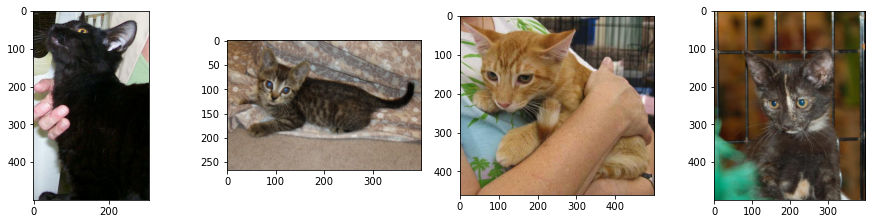

In [13]:
show_img_dataset(directory=dira,  names=imagesCats)

## Both Models without data augmentation

In [14]:

model0 = get_model(0)

Metal device set to: Apple M1 Pro


2022-07-22 12:40:37.980001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-22 12:40:37.980123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 85264)             0         
                                                                 
 dense (Dense)               (None, 128)               10913920  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,914,833
Trainable params: 10,914,833
Non-trainable params: 0
____________________________________________

In [16]:
 #create the model2
#a model with more convutionals and Pooling layers obtains leess parameters. 
model1 = get_model(1)

In [17]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 147, 147, 16)      784       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 70, 70, 32)        8224      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        32832     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)      

In [18]:
#compile models 

#optim = Adam()
optim=RMSprop(learning_rate=0.001)

#binary_crossentropy is a loss function that works really weel with binary clasifications. 
model0.compile(loss="binary_crossentropy",  
              optimizer=optim, 
              metrics=['accuracy'])
model1.compile(loss="binary_crossentropy", 
              optimizer=optim, 
              metrics=['accuracy'])

In [19]:
#Training the model
#epochs * steps_per_epoch * batch_size

train_data, val_data = SimpleDataGenerator()

history0 = model0.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Found 21000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Epoch 1/30


2022-07-22 12:40:38.653558: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-22 12:40:38.876235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 1.2551 - accuracy: 0.6163

2022-07-22 12:41:09.018363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/pere/miniforge3/envs/mlenv/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


200/200 [==============================] - 36s 179ms/step - loss: 1.2551 - accuracy: 0.6163 - val_loss: 0.7197 - val_accuracy: 0.5703
Epoch 2/30
200/200 [==============================] - 36s 180ms/step - loss: 0.5548 - accuracy: 0.7218 - val_loss: 0.5470 - val_accuracy: 0.7274
Epoch 3/30
200/200 [==============================] - 36s 181ms/step - loss: 0.4916 - accuracy: 0.7688 - val_loss: 0.5251 - val_accuracy: 0.7421
Epoch 4/30
200/200 [==============================] - 36s 180ms/step - loss: 0.4258 - accuracy: 0.8026 - val_loss: 0.5347 - val_accuracy: 0.7451
Epoch 5/30
200/200 [==============================] - 36s 178ms/step - loss: 0.3569 - accuracy: 0.8419 - val_loss: 0.5489 - val_accuracy: 0.7446
Epoch 6/30
200/200 [==============================] - 36s 180ms/step - loss: 0.2866 - accuracy: 0.8825 - val_loss: 0.6731 - val_accuracy: 0.7136
Epoch 7/30
200/200 [==============================] - 36s 181ms/step - loss: 0.2291 - accuracy: 0.9102 - val_loss: 0.6404 - val_accuracy: 0.7

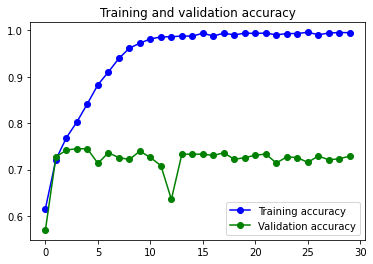

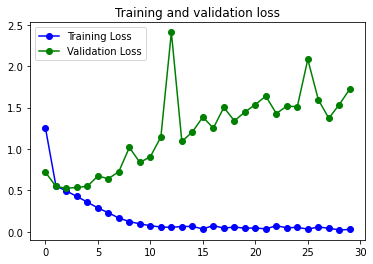

In [20]:
plot_loss_acc(history0)

In [21]:
#Training the model1
history1 = model1.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30


2022-07-22 12:58:04.048318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.8044 - accuracy: 0.6019

2022-07-22 12:58:34.836179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 37s 182ms/step - loss: 0.8044 - accuracy: 0.6019 - val_loss: 0.5622 - val_accuracy: 0.7096
Epoch 2/30
200/200 [==============================] - 36s 182ms/step - loss: 0.5578 - accuracy: 0.7109 - val_loss: 0.4656 - val_accuracy: 0.7819
Epoch 3/30
200/200 [==============================] - 36s 180ms/step - loss: 0.4806 - accuracy: 0.7722 - val_loss: 0.5150 - val_accuracy: 0.7496
Epoch 4/30
200/200 [==============================] - 36s 180ms/step - loss: 0.4091 - accuracy: 0.8124 - val_loss: 0.4152 - val_accuracy: 0.8217
Epoch 5/30
200/200 [==============================] - 36s 180ms/step - loss: 0.3467 - accuracy: 0.8454 - val_loss: 0.4270 - val_accuracy: 0.8017
Epoch 6/30
200/200 [==============================] - 36s 180ms/step - loss: 0.2841 - accuracy: 0.8780 - val_loss: 0.3711 - val_accuracy: 0.8387
Epoch 7/30
200/200 [==============================] - 36s 179ms/step - loss: 0.2181 - accuracy: 0.9094 - val_loss: 0.4438 - val_accuracy: 0.8

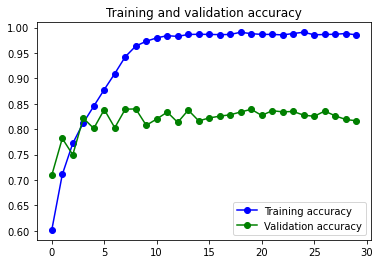

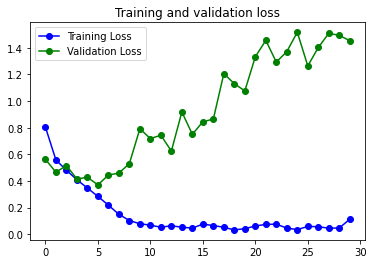

In [22]:

plot_loss_acc(history1)

## Solve OVERFITTING with Image Augmentation
Image augmentation add variations to the images reducing the overfitting. 





In [23]:
#Training the model0
#with the new imagegenerator

train_data, val_data = AugmentationDataGenerator()

historyda0 = model0.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Found 21000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Epoch 1/30
200/200 [==============================] - 83s 413ms/step - loss: 0.7203 - accuracy: 0.5814 - val_loss: 0.6545 - val_accuracy: 0.6646
Epoch 2/30
200/200 [==============================] - 99s 496ms/step - loss: 0.6497 - accuracy: 0.6178 - val_loss: 0.6103 - val_accuracy: 0.6488
Epoch 3/30
200/200 [==============================] - 85s 425ms/step - loss: 0.6231 - accuracy: 0.6532 - val_loss: 0.6134 - val_accuracy: 0.6416
Epoch 4/30
200/200 [==============================] - 84s 419ms/step - loss: 0.6100 - accuracy: 0.6659 - val_loss: 0.5528 - val_accuracy: 0.7211
Epoch 5/30
200/200 [==============================] - 83s 414ms/step - loss: 0.6024 - accuracy: 0.6755 - val_loss: 0.5466 - val_accuracy: 0.7246
Epoch 6/30
200/200 [==============================] - 83s 415ms/step - loss: 0.5964 - accuracy: 0.6751 - val_loss: 0.5479 - val_accuracy: 0.7199
Epoch 7/30
200/200 [=========================

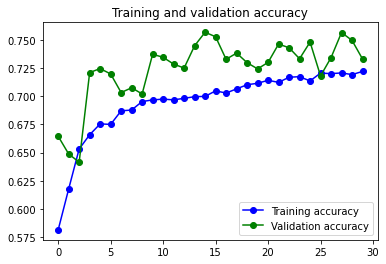

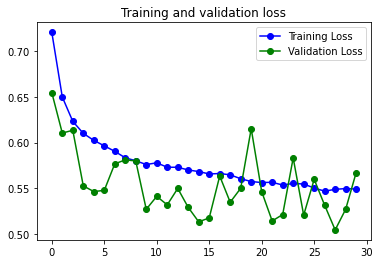

In [24]:
plot_loss_acc(historyda0)

In [25]:
#Traning the model1
historyda1 = model1.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30
200/200 [==============================] - 84s 417ms/step - loss: 0.6216 - accuracy: 0.6880 - val_loss: 0.4645 - val_accuracy: 0.7771
Epoch 2/30
200/200 [==============================] - 83s 416ms/step - loss: 0.5391 - accuracy: 0.7359 - val_loss: 0.4342 - val_accuracy: 0.8047
Epoch 3/30
200/200 [==============================] - 83s 416ms/step - loss: 0.5220 - accuracy: 0.7474 - val_loss: 0.4441 - val_accuracy: 0.8054
Epoch 4/30
200/200 [==============================] - 85s 424ms/step - loss: 0.5010 - accuracy: 0.7635 - val_loss: 0.4338 - val_accuracy: 0.8142
Epoch 5/30
200/200 [==============================] - 84s 417ms/step - loss: 0.4877 - accuracy: 0.7700 - val_loss: 0.4320 - val_accuracy: 0.8082
Epoch 6/30
200/200 [==============================] - 84s 418ms/step - loss: 0.4761 - accuracy: 0.7763 - val_loss: 0.3999 - val_accuracy: 0.8307
Epoch 7/30
200/200 [==============================] - 83s 416ms/step - loss: 0.4701 - accuracy: 0.7820 - val_loss: 0.4713 - val_ac

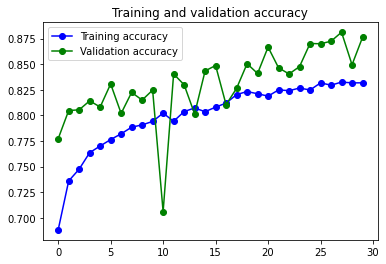

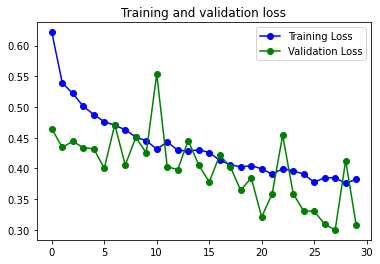

In [26]:
plot_loss_acc(historyda1)

## Dropout layers to the models
A dropout layer can help with the overfitting reducing the amount of information in every image. 

In [27]:
#create the model with a dropout layer. 
#it's a minimal model for images, with just an Convolutionatl layer and a MaxPooling layer
modelDrop0 = get_model(3)

In [28]:
 #create the model with dropouts layers. 
#a model with more convutionals and Pooling layers obtains leess parameters. 
modelDrop1 = get_model(4)


In [34]:
#compile the dropout models 
from tensorflow.keras.optimizers import RMSprop
#binary_crossentropy is a loss function that works really weel with binary clasifications. 
modelDrop0.compile(loss="binary_crossentropy", 
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['accuracy'])
modelDrop1.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=['accuracy'])

In [35]:
#Training the model
#with the new imagegeneratorhttps://www.youtube.com/watch?v=LE3NfEULV6k

historyDrop0 = modelDrop0.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30


2022-07-22 18:02:53.878117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7260

2022-07-22 18:04:11.062767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 83s 413ms/step - loss: 0.5468 - accuracy: 0.7260 - val_loss: 0.5002 - val_accuracy: 0.7586
Epoch 2/30
200/200 [==============================] - 84s 417ms/step - loss: 0.5416 - accuracy: 0.7351 - val_loss: 0.5781 - val_accuracy: 0.7324
Epoch 3/30
200/200 [==============================] - 84s 419ms/step - loss: 0.5358 - accuracy: 0.7318 - val_loss: 0.5131 - val_accuracy: 0.7596
Epoch 4/30
200/200 [==============================] - 84s 420ms/step - loss: 0.5370 - accuracy: 0.7339 - val_loss: 0.5041 - val_accuracy: 0.7609
Epoch 5/30
200/200 [==============================] - 85s 424ms/step - loss: 0.5343 - accuracy: 0.7359 - val_loss: 0.5514 - val_accuracy: 0.7524
Epoch 6/30
200/200 [==============================] - 84s 421ms/step - loss: 0.5396 - accuracy: 0.7314 - val_loss: 0.5327 - val_accuracy: 0.7431
Epoch 7/30
200/200 [==============================] - 86s 427ms/step - loss: 0.5365 - accuracy: 0.7320 - val_loss: 0.5097 - val_accuracy: 0.7

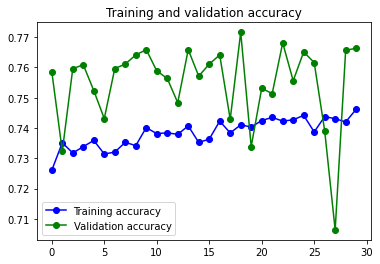

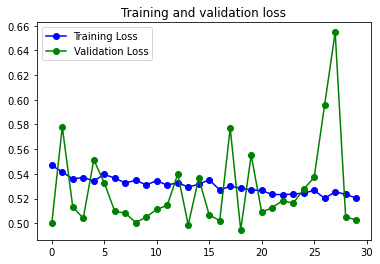

In [37]:
plot_loss_acc(historyDrop0)

In [36]:
#Training the model2
historyDrop1 = modelDrop1.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30


2022-07-22 18:45:07.957819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8232

2022-07-22 18:46:27.153324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 85s 422ms/step - loss: 0.3935 - accuracy: 0.8232 - val_loss: 0.3400 - val_accuracy: 0.8587
Epoch 2/30
200/200 [==============================] - 84s 421ms/step - loss: 0.3803 - accuracy: 0.8289 - val_loss: 0.3379 - val_accuracy: 0.8549
Epoch 3/30
200/200 [==============================] - 84s 421ms/step - loss: 0.3705 - accuracy: 0.8348 - val_loss: 0.3501 - val_accuracy: 0.8494
Epoch 4/30
200/200 [==============================] - 84s 420ms/step - loss: 0.3684 - accuracy: 0.8357 - val_loss: 0.3439 - val_accuracy: 0.8534
Epoch 5/30
200/200 [==============================] - 84s 420ms/step - loss: 0.3712 - accuracy: 0.8325 - val_loss: 0.3429 - val_accuracy: 0.8467
Epoch 6/30
200/200 [==============================] - 84s 420ms/step - loss: 0.3612 - accuracy: 0.8391 - val_loss: 0.4046 - val_accuracy: 0.8157
Epoch 7/30
200/200 [==============================] - 84s 421ms/step - loss: 0.3583 - accuracy: 0.8410 - val_loss: 0.3175 - val_accuracy: 0.8

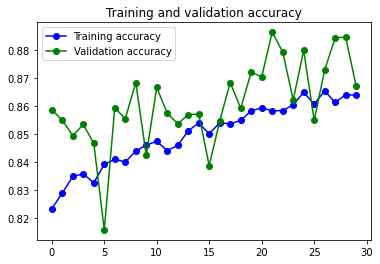

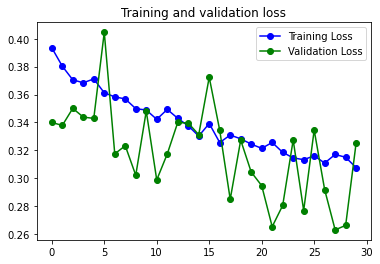

In [38]:
plot_loss_acc(historyDrop1)

# TRANSFER LEARNING
When thansfer learning we get advantage of a pretrained model. Normally a big model trained by a big company with a lo t of training hours and data. 

    1.Shape the data model to fit in our model. 
    
    2.Pick the layers we want from the trained model. 
    
        2.a.Freeze the layers choosed. 
        
    3.Add Dense layers. 
    
        3a.Train the layers added. 


In [68]:
from tensorflow.keras import Model

# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    
    #https://tfhub.dev/google/imagenet/inception_v3/classification/5

--2022-07-23 19:51:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.178.176, 172.217.168.176, 142.250.200.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.178.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83,84M  28,8MB/s    in 2,9s    

2022-07-23 19:51:52 (28,8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [49]:
#conver layers in non trainable. 
def notrainlayers(model):
    for layer in model.layers:
        layer.trainable=False
    return model 
    

## Transfer learning from Inceptionv3


In [62]:
#store name of the file in a variable. 
local_weigth_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#import Inceptionv3. 
from tensorflow.keras.applications.inception_v3 import InceptionV3

#create the model. 
inception_pre_trained=InceptionV3(input_shape=(150, 150, 3), 
                                 include_top=False, 
                                 weights=None)

#load the weights, obtained downloading 
inception_pre_trained.load_weights(local_weigth_file)


In [63]:
inception_pre_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_220 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 16, 16, 96)  288         ['conv2d_230[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 16, 16, 32)  96          ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_193 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_193[0][0]']
                                                                                                  
 activatio

 activation_210 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_240 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_243 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_normalization_208 (Batch  (None, 16, 16, 48)  144         ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_211 (Batch  (None, 16, 16, 96)  288         ['conv2d_243[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_254 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_222 (Batch  (None, 7, 7, 128)   384         ['conv2d_254[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_222 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_222[0][0]']
          

                                                                                                  
 batch_normalization_232 (Batch  (None, 7, 7, 160)   480         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_265 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_232[0][0]']         
                                                                                                  
 batch_normalization_233 (Batch  (None, 7, 7, 160)   480         ['conv2d_265[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_275 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 7, 7, 160)   480         ['conv2d_275[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_243 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_271 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_27

                                                                                                  
 activation_253 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_281 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_286 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_253[0][0]']         
                                                                                                  
 batch_normalization_249 (Batch  (None, 7, 7, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_294 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 7, 7, 192)   576         ['conv2d_290[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 7, 7, 192)   576         ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_258[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_266 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_267[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_270[0][0]']
                                                                                                  
 activation_271 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_271[0][0]']
                                                                                                  
 batch_normalization_272 (Batch  (None, 3, 3, 192)   576         ['conv2d_304[0][0]']             
 Normaliza

                                                                                                  
 activation_280 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 3, 3, 192)   576         ['conv2d_313[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_273 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_273[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_275[0][0]',         
                                                                  'activation_276[0][0]']         
          

In [64]:
inception_pre_trained = notrainlayers(inception_pre_trained)

In [65]:
inception_pre_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_220 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 16, 16, 96)  288         ['conv2d_230[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 16, 16, 32)  96          ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_193 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_193[0][0]']
                                                                                                  
 activatio

 activation_210 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_240 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_243 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_normalization_208 (Batch  (None, 16, 16, 48)  144         ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_211 (Batch  (None, 16, 16, 96)  288         ['conv2d_243[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_254 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_222 (Batch  (None, 7, 7, 128)   384         ['conv2d_254[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_222 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_222[0][0]']
          

                                                                                                  
 batch_normalization_232 (Batch  (None, 7, 7, 160)   480         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_265 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_232[0][0]']         
                                                                                                  
 batch_normalization_233 (Batch  (None, 7, 7, 160)   480         ['conv2d_265[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_275 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 7, 7, 160)   480         ['conv2d_275[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_243 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_271 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_27

                                                                                                  
 activation_253 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_281 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_286 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_253[0][0]']         
                                                                                                  
 batch_normalization_249 (Batch  (None, 7, 7, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_294 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 7, 7, 192)   576         ['conv2d_290[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 7, 7, 192)   576         ['conv2d_294[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_258[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_266 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_267[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_270[0][0]']
                                                                                                  
 activation_271 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_271[0][0]']
                                                                                                  
 batch_normalization_272 (Batch  (None, 3, 3, 192)   576         ['conv2d_304[0][0]']             
 Normaliza

                                                                                                  
 activation_280 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 3, 3, 192)   576         ['conv2d_313[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_273 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_273[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_275[0][0]',         
                                                                  'activation_276[0][0]']         
          

In [66]:
#select the last layer we want from the pretrained model
last_layer = inception_pre_trained.get_layer('mixed7')
last_output = last_layer.output



In [69]:
#Flatten the output layer to 1 dimension
flayers = tf.keras.layers.Flatten()(last_output)

#add a fullly connected layer woth 512 neurons the samen that with the others models. 
flayers = tf.keras.layers.Dense(512, activation='relu')(flayers)

#add a final sigmoid layer for binary classification
flayers = tf.keras.layers.Dense(1, activation='sigmoid')(flayers)

#append the final layers to the pretrained layer and create a new model
modelf = Model(inception_pre_trained.input, flayers)

modelf.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_220 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                              

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 16, 16, 96)  288         ['conv2d_230[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 16, 16, 32)  96          ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_193 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_193[0][0]']
                                                                                                  
 activatio

 activation_210 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_240 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_243 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_normalization_208 (Batch  (None, 16, 16, 48)  144         ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_211 (Batch  (None, 16, 16, 96)  288         ['conv2d_243[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_254 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_222 (Batch  (None, 7, 7, 128)   384         ['conv2d_254[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_222 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_222[0][0]']
          

                                                                                                  
 batch_normalization_232 (Batch  (None, 7, 7, 160)   480         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_265 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_232[0][0]']         
                                                                                                  
 batch_normalization_233 (Batch  (None, 7, 7, 160)   480         ['conv2d_265[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_275 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 7, 7, 160)   480         ['conv2d_275[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_243 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_271 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_27

                                                                                                  
 activation_253 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_281 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_286 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_253[0][0]']         
                                                                                                  
 batch_normalization_249 (Batch  (None, 7, 7, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [71]:
modelf.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=['accuracy'])

In [72]:
#Training the model2
historyF = modelf.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30


2022-07-23 19:55:16.602003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8947

2022-07-23 19:56:36.821527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/pere/miniforge3/envs/mlenv/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


200/200 [==============================] - 89s 428ms/step - loss: 0.3134 - accuracy: 0.8947 - val_loss: 0.1043 - val_accuracy: 0.9592
Epoch 2/30
200/200 [==============================] - 85s 425ms/step - loss: 0.1773 - accuracy: 0.9263 - val_loss: 0.0934 - val_accuracy: 0.9627
Epoch 3/30
200/200 [==============================] - 87s 432ms/step - loss: 0.1565 - accuracy: 0.9360 - val_loss: 0.0945 - val_accuracy: 0.9615
Epoch 4/30
200/200 [==============================] - 85s 423ms/step - loss: 0.1464 - accuracy: 0.9397 - val_loss: 0.0906 - val_accuracy: 0.9640
Epoch 5/30
200/200 [==============================] - 86s 430ms/step - loss: 0.1405 - accuracy: 0.9407 - val_loss: 0.0938 - val_accuracy: 0.9630
Epoch 6/30
200/200 [==============================] - 86s 429ms/step - loss: 0.1347 - accuracy: 0.9450 - val_loss: 0.0821 - val_accuracy: 0.9655
Epoch 7/30
200/200 [==============================] - 86s 428ms/step - loss: 0.1286 - accuracy: 0.9467 - val_loss: 0.0787 - val_accuracy: 0.9

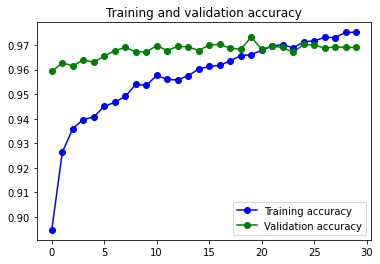

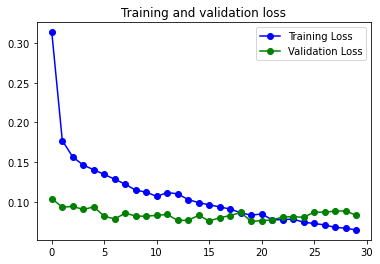

In [73]:
plot_loss_acc(historyF)

   ## Transfer learning VGG16 Model. 

In [81]:
from keras.applications.vgg16 import VGG16

#https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_pre_trained = VGG16(input_shape=(150, 150, 3), 
                       include_top=False, 
                       weights='imagenet')

In [82]:
VGG16_pre_trained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [83]:
VGG16_pre_trained = notrainlayers(VGG16_pre_trained)

In [93]:

modelVGG = tf.keras.models.Sequential()
modelVGG.add(VGG16_pre_trained)


#Flatten the output layer to 1 dimension
modelVGG.add(tf.keras.layers.Flatten())

#add a fullly connected layer woth 512 neurons the samen that with the others models. 
modelVGG.add(tf.keras.layers.Dense(512, activation='relu'))

#add a final sigmoid layer for binary classification
#flayersV = tf.keras.layers.Dense(1, activation='sigmoid')(flayers)
modelVGG.add(tf.keras.layers.Dense(1, activation='sigmoid'))

modelVGG.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_32 (Flatten)        (None, 8192)              0         
                                                                 
 dense_54 (Dense)            (None, 512)               4194816   
                                                                 
 dense_55 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [98]:
modelVGG.compile(loss="binary_crossentropy", 
              optimizer='Adam', 
              metrics=['accuracy'])

In [99]:
#Training the model2
historyVGG = modelVGG.fit(
     train_data,
     validation_data = val_data, 
     epochs=gEpochs,
     steps_per_epoch=len(train_data),
     validation_steps=len(val_data),
     verbose=1)

Epoch 1/30


2022-07-24 00:31:33.224391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8067

2022-07-24 00:33:16.966761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 122s 603ms/step - loss: 0.4289 - accuracy: 0.8067 - val_loss: 0.2868 - val_accuracy: 0.8722
Epoch 2/30
200/200 [==============================] - 118s 587ms/step - loss: 0.3462 - accuracy: 0.8451 - val_loss: 0.2472 - val_accuracy: 0.8942
Epoch 3/30
200/200 [==============================] - 118s 586ms/step - loss: 0.3201 - accuracy: 0.8555 - val_loss: 0.2440 - val_accuracy: 0.8967
Epoch 4/30
200/200 [==============================] - 120s 596ms/step - loss: 0.3136 - accuracy: 0.8597 - val_loss: 0.2373 - val_accuracy: 0.9017
Epoch 5/30
200/200 [==============================] - 118s 586ms/step - loss: 0.2951 - accuracy: 0.8694 - val_loss: 0.2576 - val_accuracy: 0.8904
Epoch 6/30
200/200 [==============================] - 118s 586ms/step - loss: 0.2938 - accuracy: 0.8692 - val_loss: 0.2567 - val_accuracy: 0.8884
Epoch 7/30
200/200 [==============================] - 120s 596ms/step - loss: 0.2871 - accuracy: 0.8716 - val_loss: 0.2273 - val_accura

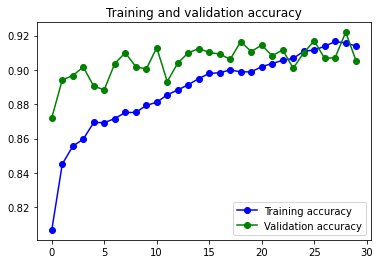

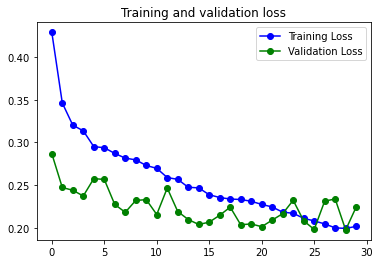

In [100]:
plot_loss_acc(historyVGG)